In [67]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
from pathlib import Path
from PIL import Image
from PIL import ImageFile
import os
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from shutil import copyfile
import matplotlib.pyplot as plt

In [68]:
def VGG16Model():
    base_model = VGG16(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x=Dense(512,activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [69]:
def VGG16ModelDropout():
    base_model = VGG16(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [70]:
def ResnetModelDropout(input_shape=(256,256,3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_shape)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [71]:
print('Classes:',os.listdir('data'))
print('No of Images per classes in training')
print(len(os.listdir('data/adult')),len(os.listdir('data/violence')))
print('No of Images per classes in validation')
print(len(os.listdir('dt/adult')),len(os.listdir('dt/violence')))


Classes: ['adult', 'violence']
No of Images per classes in training
318 260
No of Images per classes in validation
72 89


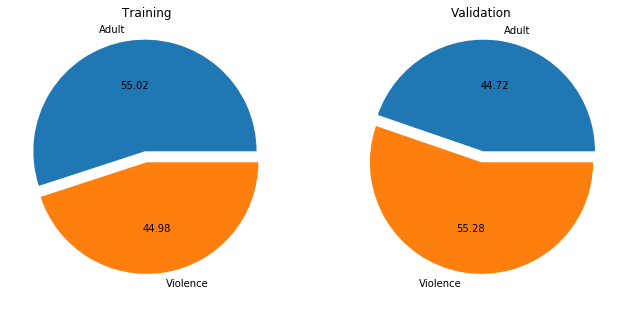

In [72]:
plt.figure(figsize=(11,11))
plt.subplot(121)
plt.title('Training')
plt.pie([len(os.listdir('data/adult')),len(os.listdir('data/violence'))],explode=(0.1,0),labels=['Adult','Violence'],autopct='%.2f')
plt.subplot(122)
plt.title('Validation')
plt.pie([len(os.listdir('dt/adult')),len(os.listdir('dt/violence'))],explode=(0.1,0),labels=['Adult','Violence'],autopct='%.2f')
plt.show()

In [73]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data', target_size=(256, 256), 
                                      color_mode='rgb', classes=None, 
                                      class_mode='binary', batch_size=4, 
                                      shuffle=True,  follow_links=False, 
                                      subset=None, interpolation='nearest')
val_generator = val_datagen.flow_from_directory(
        'dt',
        target_size=(256, 256),
        batch_size=64,
        class_mode='binary')

Found 578 images belonging to 2 classes.
Found 161 images belonging to 2 classes.


In [74]:
def plot_accuracy(x,history_cnn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title("Accuracy comparison")
    plt.plot(x,history_cnn.history['acc'],label='Train')
    plt.plot(x,history_cnn.history['val_acc'],label='Test')
    plt.legend()
    plt.show()

def plot_loss(x,history_cnn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title("Loss comparison")
    plt.plot(x,history_cnn.history['loss'],label='Train')
    plt.plot(x,history_cnn.history['val_loss'],label='Test')
    plt.legend()
    plt.show()

def plot_precision(x,history_cnn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title("Precision comparison")
    plt.plot(x,history_cnn.history['precision'],label='Train')
    plt.plot(x,history_cnn.history['val_precision'],label='Test')
    plt.legend()
    plt.show()
def plot_recall(x,history_cnn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title("Recall comparison")
    plt.plot(x,history_cnn.history['recall'],label='Train')
    plt.plot(x,history_cnn.history['val_recall'],label='Test')
    plt.legend()
    plt.show()
    
def plot_f1(x,history_cnn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title("F1Score comparison")
    plt.plot(x,history_cnn.history['f1_score'],label='Train')
    plt.plot(x,history_cnn.history['val_f1_score'],label='Test')
    plt.legend()
    plt.show()

In [75]:
train_filenames=train_generator.filenames
print('Train Size : {}'.format(len(train_filenames)))

model = VGG16ModelDropout()


Train Size : 578


In [76]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper


precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)
f1_score=as_keras_metric(tf.contrib.metrics.f1_score)

In [37]:
# # ---------1st Step of Training-----------------
for layer in model.layers[:-4]:
    layer.trainable = False

optimiz=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimiz, loss='binary_crossentropy',
              metrics=['accuracy'
                       ,precision, recall,f1_score
                      ])



print(model.summary())
ImageFile.LOAD_TRUNCATED_IMAGES = True

print('-----Training-------')
history1 = model.fit_generator(train_generator,
                    steps_per_epoch=235,
                    validation_data=val_generator,
                    validation_steps=50, 
                    epochs=10)
print("Saving Weights")
model.save_weights('model_weights/vgg_stage-1.hdf5')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

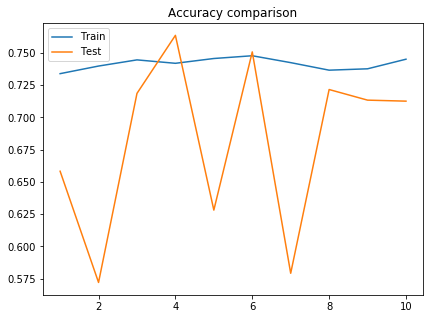

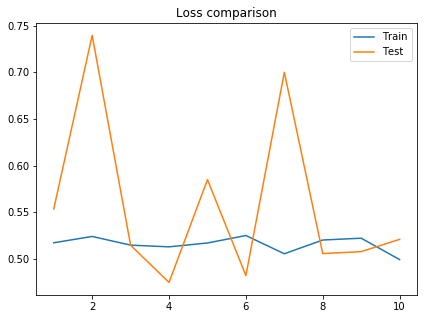

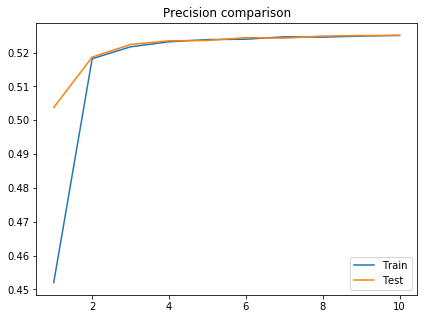

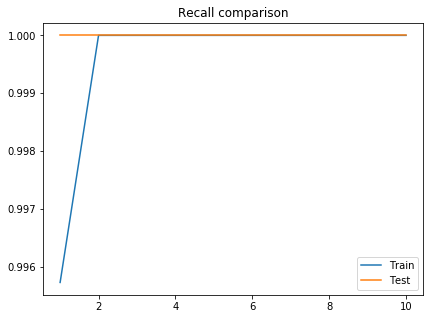

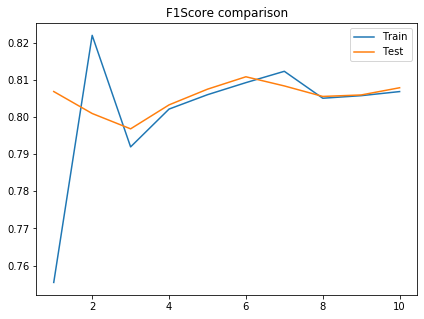

In [77]:
x = [i for i in range(1,11)]
plot_accuracy(x,history1)
plot_loss(x,history1)
plot_precision(x,history1)
plot_recall(x,history1)
plot_f1(x,history1)

In [43]:
# # ---------2nd Step of Training-----------------

for layer in model.layers:
    layer.trainable = True
for layer in model.layers[:-8]:
    layer.trainable = False

optimiz=keras.optimizers.Adam(lr=0.00025, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimiz, loss='binary_crossentropy',
              metrics=['accuracy'
                       ,precision, recall,f1_score
                       ])


print(model.summary())
ImageFile.LOAD_TRUNCATED_IMAGES = True
model.load_weights('model_weights/vgg_stage-1.hdf5')
print('-----Training-------')
history2 = model.fit_generator(train_generator,
                    steps_per_epoch=235,
                    validation_data=val_generator,
                    validation_steps=50, 
                    epochs=3)
print("-------Saving Weights---------")
model.save_weights('model_weights/vgg_stage-2.hdf5')

print("---------Done--------------")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

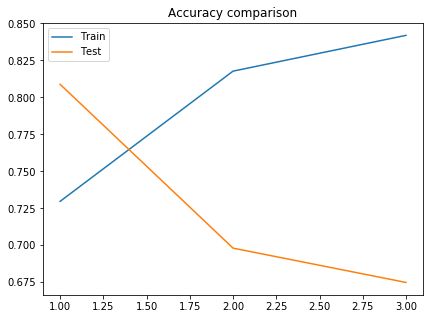

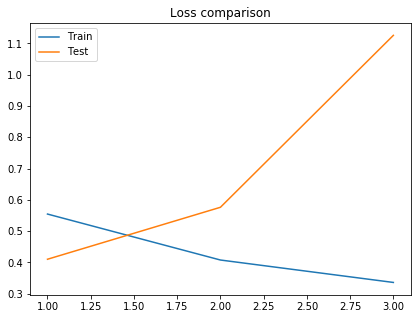

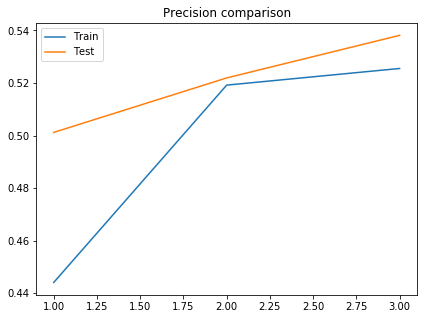

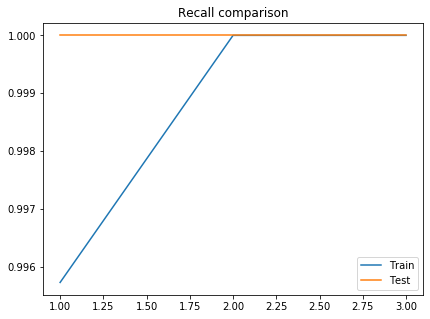

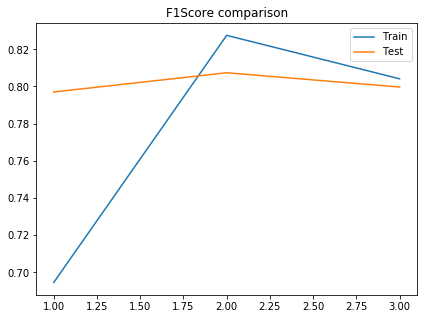

In [78]:
x = [i for i in range(1,4)]
plot_accuracy(x,history2)
plot_loss(x,history2)
plot_precision(x,history2)
plot_recall(x,history2)
plot_f1(x,history2)

In [45]:
# ---------3rd Step of Training-----------


for layer in model.layers:
 layer.trainable = True

optimiz=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(optimizer=optimiz, loss='binary_crossentropy',
           metrics=['accuracy'])


print(model.summary())
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.load_weights('model_weights/vgg_stage-2.hdf5')
print('-----Training-------')
history3 = model.fit_generator(train_generator,
                 steps_per_epoch=235,
                 validation_data=val_generator,
                 validation_steps=50, 
                 epochs=10)
print("-------Saving Weights---------")
model.save_weights('model_weights/vgg_stage-3.hdf5')

print("---------Done--------------")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

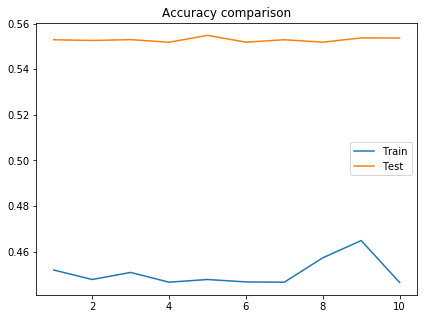

In [79]:
x = [i for i in range(1,11)]
plot_accuracy(x,history3)


In [47]:
# # ---------4th Step of Training-----------


for layer in model.layers:
 layer.trainable = True

optimiz=keras.optimizers.Adam(lr=0.000025, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(optimizer=optimiz, loss='binary_crossentropy',
           metrics=['accuracy'])


print(model.summary())
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.load_weights('model_weights/vgg_stage-3.hdf5')
print('-----Training-------')
history4 = model.fit_generator(train_generator,
                 steps_per_epoch=235,
                 validation_data=val_generator,
                 validation_steps=50, 
                 epochs=10)
print("-------Saving Weights---------")
model.save_weights('model_weights/vgg_stage-4.hdf5')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

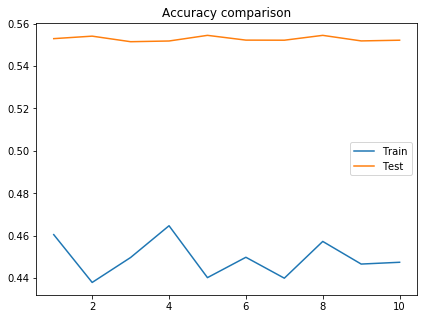

In [80]:
x = [i for i in range(1,11)]
plot_accuracy(x,history4)


In [49]:
# # ---------5th Step of Training Adding Dropout-----------

for layer in model.layers:
    layer.trainable = True
optimiz=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimiz, loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
ImageFile.LOAD_TRUNCATED_IMAGES = True
#model.load_weights('model_weights/vgg_stage-2.hdf5')
print('-----Training-------')
history5 = model.fit_generator(train_generator,
                    steps_per_epoch=442,
                    validation_steps=99, 
                    validation_data=val_generator,
                    epochs=7,verbose=1)
print("-------Saving Weights---------")
model.save_weights('model_weights/vgg_stage-2-dropout.hdf5')

print("---------Done--------------")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

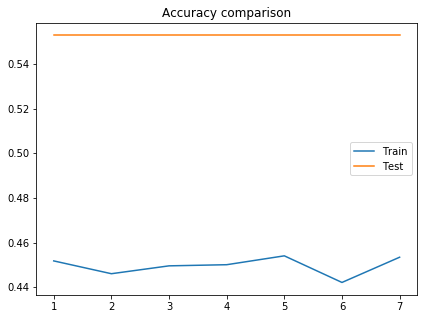

In [81]:
x = [i for i in range(1,8)]
plot_accuracy(x,history5)


In [82]:
def test(image_loc): 
    image = plt.imread(image_loc)
    image = cv2.resize(image, (256,256))
    std_img = np.array(image, dtype = np.float16)/255.0
    std_img = std_img.reshape(-1,256,256,3)
    model=VGG16ModelDropout()
    optimiz=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optimiz, loss='binary_crossentropy',
                  metrics=['accuracy'
    # #                        ,precision, recall,f1_score
                          ])

    model.load_weights('model_weights/vgg_stage-2-dropout.hdf5')
    yhat = model.predict(std_img)
    print(yhat)
    

In [83]:
test('dt/adult/0.960,nUttjmXvcAg.jpg')

[[1.]]
